In [1]:
import math
import numpy as np
import torch
from torch import nn
from d2l import torch as d2l

In [2]:
max_degree = 20 #多项式的最大阶数
n_train, n_test = 100, 100  #训练和测试数据集大小
true_w = np.zeros(max_degree)   #分配大量的空间
true_w[0:4] = np.array([5, 1.2, -3.4, 5.6])

features = np.random.normal(size=(n_train+n_test, 1))
np.random.shuffle(features)
poly_features = np.power(features, np.arange(max_degree).reshape(1, -1))
for i in range(max_degree):
    poly_features[:, i] /= math.gamma(i+1)  #gamma(n)=(n-1)!
# labels的维度:(n_train+n_test, )
labels = np.dot(poly_features, true_w)
labels += np.random.normal(scale=0.1, size=labels.shape)

In [4]:
true_w, features, poly_features, labels = [torch.tensor(x, dtype=
    torch.float32) for x in [true_w, features, poly_features, labels]]
features[:2], poly_features[:2, :], labels[:2]

/tmp/ipykernel_46236/3160376386.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  true_w, features, poly_features, labels = [torch.tensor(x, dtype=


(tensor([[-1.5602],
         [-1.1461]]),
 tensor([[ 1.0000e+00, -1.5602e+00,  1.2172e+00, -6.3302e-01,  2.4691e-01,
          -7.7048e-02,  2.0035e-02, -4.4657e-03,  8.7094e-04, -1.5099e-04,
           2.3557e-05, -3.3413e-06,  4.3444e-07, -5.2140e-08,  5.8108e-09,
          -6.0441e-10,  5.8938e-11, -5.4093e-12,  4.6887e-13, -3.8503e-14],
         [ 1.0000e+00, -1.1461e+00,  6.5674e-01, -2.5089e-01,  7.1885e-02,
          -1.6477e-02,  3.1474e-03, -5.1530e-04,  7.3822e-05, -9.4006e-06,
           1.0774e-06, -1.1225e-07,  1.0721e-08, -9.4512e-10,  7.7370e-11,
          -5.9115e-12,  4.2344e-13, -2.8547e-14,  1.8176e-15, -1.0964e-16]]),
 tensor([-4.5343,  0.1746]))

In [5]:
def evaluate_loss(net, data_iter, loss):    #@save
    """评估给定数据集上模型的损失"""
    metric = d2l.Accumulator(2) #损失的总和，样本数量
    for X, y in data_iter:
        out = net(X)
        y = y.reshape(out.shape)
        l = loss(out, y)
        metric.add(l.sum(), l.numel())
    return metric[0]/metric[1]

In [6]:
def train(train_features, test_features, train_labels, test_labels,
          num_epochs=400):
    loss = nn.MSELoss(reduction='none')
    input_shape = train_features.shape[-1]
    #不设置偏置，因为在在多项式中实现了它
    net = nn.Sequential(nn.Linear(input_shape, 1, bias=False))
    batch_size=min(10, train_labels.shape[0])
    train_iter = d2l.load_array((train_features, train_labels.reshape(-1, 1)),
                                batch_size)
    test_iter = d2l.load_array((test_features, test_labels.reshape(-1, 1)),
                               batch_size, is_train=False)
    trainer = torch.optim.SGD(net.parameters(), lr=0.01)
    animator = d2l.Animator(xlabel='epoch', ylabel='loss', yscale='log',
                            xlim=[1, num_epochs], ylim=[1e-3, 1e2],
                            legend=['train', 'test'])
    for epoch in range(num_epochs):
        d2l.train_epoch_ch3(net, train_iter, loss, trainer)
        if epoch == 0 or (epoch+1)%20 == 0:
            animator.add(epoch+1, (evaluate_loss(net, train_iter, loss),
                                   evaluate_loss(net, test_iter, loss)))
    print('weights:', net[0].weight.data.numpy())

weights: [[ 5.0178733  1.1906531 -3.4014733  5.604694 ]]


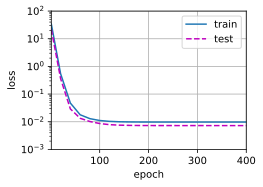

In [7]:
#从多项式特征中选择前四个维度：1, x, x^2/2!, x^3/3!
train(poly_features[:n_train, :4], poly_features[n_train:, :4],
      labels[:n_train], labels[n_train:])

weights: [[3.192148 4.804381]]


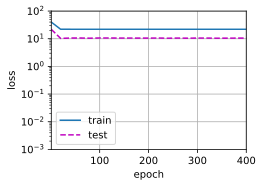

In [8]:
#从多项式特征中选择前两个维度：1, x
train(poly_features[:n_train, :2], poly_features[n_train:, :2],
      labels[:n_train], labels[n_train:])

weights: [[ 4.9628420e+00  1.4262699e+00 -3.2055449e+00  4.7179279e+00
  -3.8192892e-01  1.1518214e+00  1.2774841e-02  1.6431586e-01
  -1.0240043e-01 -1.8766955e-01 -7.9860225e-02  5.7742313e-02
   4.1555725e-03  1.2208788e-01 -9.3091160e-02 -1.4697678e-01
  -1.0646657e-01  1.6930331e-01 -4.3388117e-02 -1.4821823e-01]]


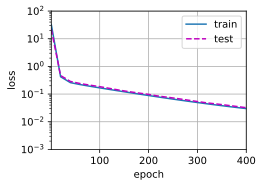

In [9]:
#从多项式特征中选择所有维度
train(poly_features[:n_train, :], poly_features[n_train:, :],
      labels[:n_train], labels[n_train:])